## W207 Machine Learning Project 4: Random Acts of Pizza
#### Team Members: Amy Huynh, Jeffrey Budiman, Kelly Nguyen



 

## Executive Summary

Our project is based off of [this Kaggle competition](https://www.kaggle.com/c/random-acts-of-pizza). **r/Random_Acts_Of_Pizza** is a subreddit where people post requests for a free pizza. Participants must create an algorithm capable of predicting which requests garner a cheesy (but sincere!) act of kindness (pizza).

To tackle this problem, we first familiarized ourself with the data. The dataset has 4,040 rows, with 44 different fields. Our output variable was `Request Success` and we had a combination of text and numerical variables. For text variables, we had `Request Title` and  `Request Message`. For numerical variables we had `# of down/up votes`, `# of comments`, `account age`, `# of days between posts`, `# of posts`, `# of subreddits`, `request timestamp`, etc.

Next, we did some basic data cleansing of the `Request Message` field. Intuitively, we thought that the Yes/No Pizza outcome would certainly be predicted using text features because people receive pizza from others that give that read their posts. Because of this, we decided to spend some time cleaning the data so that we could better work with it. We removed punctuation, common emoticons, stopwords, and extra whitespace. Additionally we lowercased all of the text and stemmed the words where applicable.

For our initial exploratory data analysis (EDA), we looked for trends in the data, graphing numerical variables of interest and skimming through posts to see if we could identify any common patterns. We decided to create a correlation matix against the output variable. This had interesting results: the highest correlated features were barely related to the actual text of the request, and instead more related to the information surrounding the post, such as `requester number of posts on raop at retrieval` or `request number of comments at retrieval`. We thought this was very interesting and maybe that the text was less important to the Yes Pizza outcome. 

After our data cleansing and EDA, we ran a few baseline models to try to give us some direction for feature engineering. For these baseline models (Logistic Regression, Random Forest, and Gaussian Naive Bayes) we did not pare down the variables, but we did include/exclude numerical vs. text variables depending on the model. Our results told us two things: (1) Numerical features related to the post itself seemed to be more influential and (2) Ensemble method models performed better.

We wanted to engineer new features based on the request text, still believing that the text itself would be the key to higher prediction accuracy. To do this, we decided to follow some of the methods used in this [research paper that we found on the Kaggle competition page](https://cs.stanford.edu/~althoff/raop-dataset/altruistic_requests_icwsm.pdf). 

Firstly, we read that the writers of the research paper performed topic modeling through non-negative matrix factorization (NMF) of a TF-IDF weighted bag-of-words representation. We ran our own LDA model to generate five topics, which resulted a dataframe containing counts for each topic. We added these new features to the train and test datasets, hoping that this would increase prediction power since the research paper had some success with the LDA-based topic modeling.

Secondly, we added Narrative topics that were discovered in the paper: "Money", "Job", "Student", "Family", and "Craving". We followed the key terms that they identified and created fields based on the existence of these key terms.

Thirdly, we added the textual, social, and
temporal features outlined in the paper. These included: Time difference between the request timestamp and the date when RAOP community started (December 8, 2010), Gratitude (Politeness), Including Images or Links (Evidentiality), Reciprocity, Request Length, Karma, and Post-History. The detailed logic for each of these can be found in each respective section of this notebook.

After our feature engineering, it was time to select the most influential features based on our PCA analysis and our correlation matrix. Most of the features that were included were numerical, related to information surrounding the post, and not so much the content of the actual post. We incorporated these features into our final models (Logistic Regression, Random Forest, Gaussian Naive Bayes, Gradient Boosting, and ADA Boosting).

Although we initially considered this Kaggle competition to be a solely Natural Language Processing (NLP) problem, we learned that this was not actually the case. Most of our final features were not related to the actual content of the request, and instead related to information surrounding the post (upvotes, number of posts by requester, etc.). Our final model selection was the Gradient Boosting model, our accuracy of `0.862`, AUC was `0.90`, and the F1-Score for True was `0.71`.

## Setting Up Our Environment

Before we pre-process the data, ensure that you have the correct version of Python. For our project, you need at least Python 3.7.11.Additionally, ensure that the the correct packages are installed (porter2stemmer and vaderSentiment).

In [ ]:
!python --version

Python 3.7.11


In [ ]:
!pip install porter2stemmer
!pip install vaderSentiment

Additionally, import the packages that will be used throughout the project.

In [ ]:
# IMPORTING PACKAGES
import pandas as pd
import numpy as np
import re
import seaborn as sns
import altair as alt
import string
import matplotlib
import matplotlib.pyplot as plt
import nltk

from nltk.corpus import stopwords
from porter2stemmer import Porter2Stemmer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, classification_report, roc_curve, auc

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MaxAbsScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier

from sklearn.decomposition import LatentDirichletAllocation, PCA

from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.model_selection import GridSearchCV

from sklearn import mixture

import datetime
from datetime import datetime, timedelta, date
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.decomposition import TruncatedSVD

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

import gensim
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
from sklearn import utils

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


/usr/local/lib/python3.7/dist-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


# Universal Functions

Throughout our project, we wrote functions to keep our code readable and resuable. Those functions are defined in this section.


In [ ]:
def eval_perf(title,actual,prediction,pred_proba):
    ''' Show f1, confusion matrix, classification report, and ROC curve
    '''

    # F1 score, Confusion Matrix, Classification Report
    f1 = f1_score(actual, prediction, average='weighted')
    cm = confusion_matrix(actual, prediction)
    creport = classification_report(actual, prediction)
    print("-"*80)
    print(title)
    print("\nAccuracy: {:.3f}\n".format(f1)) 
    print(creport)
    print("\nConfusion Matrix: ")
    plt.figure(figsize=(3,3))
    sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues_r', annot_kws={"fontsize":17});
    plt.ylabel('Actual', fontsize=14);
    plt.xlabel('Predicted', fontsize=14); 
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

    # ROC
    fpr, tpr, th = roc_curve(actual, pred_proba[:,1])
    auc_score = auc(fpr, tpr)
    plt.figure(figsize=(6,6))
    plt.title(title, fontsize=17)
    plt.grid(linestyle='dotted')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % auc_score)
    plt.legend(loc = 'lower right', fontsize=15)
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate', fontsize=15)
    plt.xlabel('False Positive Rate', fontsize=15)

def text_cleaning(text):
    ''' preprocess text by removing emotingons --> removing numbers 
                          --> removing 2 letter words --> stripping punctuation 
                          --> removing stopwords --> removing extra whitespace
                          --> stemming words
    '''
    stop = list(set(stopwords.words('english')))
    stemmer = Porter2Stemmer()

    text = re.sub(r'(?:\(|\)|c|D|C|p|P|o|O|\||\[|\])\:', '', text)
    text = re.sub(r'\:(?:\(|\)|c|D|C|p|P|o|O|\||\[|\])', '', text)
    text = re.sub(r'[0-9]+', '', text)
    text = re.sub(r'\b[a-zA-Z]{1,2}\b', '', text)
    text = text.lower().translate(str.maketrans('', '', string.punctuation))
    text =  " ".join(word for word in text.split(" ") if word not in stop)
    text = re.sub(r'\s{2,}', ' ', text)
    text = " ".join(stemmer.stem(word) for word in text.split(" "))

    return text


def train_base_models(model_name, type_feat):
  '''
  type_feat should be: numeric, text, or all
  model name should be a key from the model_dict

  this function takes in required parameters and trains a model and returns out f1 scores, confustion matrix, and the ROC curve
  '''
  model_dict = {
      'logistic': LogisticRegression(class_weight = 'balanced'),
      'gaussian_nb': GaussianNB(),
      'random_forest': RandomForestClassifier()
  } 

  pipeline_text=[] # we need this pipeline portion to unionize both numeric and text features from a CountVectorizer because passing them in as is will not work

  for ix, text_col in enumerate(train_text_cols): # create pipeline for each text column
      pipeline_text.append((text_col, Pipeline([('extract', ColumnExtractor(train_text_cols[ix])),
              ('vect', CountVectorizer(ngram_range=(1, 1), analyzer='word'))
                          ])))
      
  pipeline_numeric = Pipeline([('extract', ColumnExtractor(train_numerical_cols)),
      ('impute', SimpleImputer(missing_values= np.nan, strategy='median')), # imputes missing values with the median value
      ('scale', MaxAbsScaler(copy=True))
      ])
  
  if type_feat == "all":
    feats = FeatureUnion([('numeric', pipeline_numeric)] 
                     + pipeline_text)
  elif type_feat == "text":
    feats = pipeline_text
  elif type_feat == "numeric":
    feats = pipeline_numeric

  pipeline = Pipeline([
    ('features', feats),
    ('clf', model_dict[model_name])])

  model = pipeline.fit(train[train_text_cols + train_numerical_cols], train_labels)

  preds = model.predict(test)
  pred_prob = model.predict_proba(test)

  if type_feat == "all":
    print(eval_perf('all features',test_labels, preds, pred_prob))
  elif type_feat == "text":
    print(eval_perf('text features',test_labels, preds, pred_prob))
  elif type_feat == "numeric":
    print(eval_perf('numeric features',test_labels, preds, pred_prob))
  
def topic_wordcount(topic_dct, text):
    ''' topic_dct: dictionary of top words grouped by topic
        text: text to be evaluated
        returns a dictionary of word count found in sentence (grouped by topic)
    '''
    ### Get word counts for each topic
    dd = {}
    for key,val in topic_dct.items():
        regex = '|'.join(val)
        dd[key] = [len(re.findall(regex, text))]

    return dd


def topicModeling(textref_sr, num_topwords=100, ntopics=5, vocablist = []):
    ''' Takes text series textref_sr which is the training data corpus
        and generates LDA-based topic groups. 
        num_topwords specifies numbers of selected top words
        ntopics specifies the numbers of topics 
        Returns a dictionary of top words grouped by topic.
    '''

    # if vocablist is not specified, create one based on textref_sr
    # if it is specified, transform data based on it
    if len(vocablist) == 0:
        cv_text = CountVectorizer()
        X_text_train = cv_text.fit_transform(textref_sr)
        vocablist = cv_text.get_feature_names()
    else:
        cv_text = CountVectorizer(vocabulary=vocablist)
        X_text_train = cv_text.transform(textref_sr)

    ### LDA model
    lda = LatentDirichletAllocation(n_components=ntopics, learning_method='online', random_state=0)
    lda.fit(X_text_train)

    ### Index of the top words, sort descending
    words_id = np.argsort(lda.components_)[:,-num_topwords:]
    words_id = words_id[:,::-1]

    ### Top Words grouped by topic
    topic_dct = {'topic'+str(r):list(np.array(vocablist)[words_id[r]]) for r in range(len(words_id))}

    return topic_dct


def genTopics(text_sr, topic_dct):
    ''' Generates Topic modeling feature.
        It generates word count of each document in text_sr with respect to the topic group 
        specified by topic_dct.
        returns dataframe with counts for each topic
    '''

    ### Create dataframe of word count by topic
    topicdf = pd.DataFrame(columns=topic_dct.keys())

    for sentence in list(text_sr):
        wc = pd.DataFrame(topic_wordcount(topic_dct, sentence))
        topicdf = pd.concat([topicdf, wc], ignore_index = True)

    topicdf = topicdf.astype(int)

    return topicdf


  # Calculate normalized narrative frequency
def calcNormfreq(text):
    ''' Calculates normalized word frequency of the sentence per narrative (word freq / sentence length)
        Narrative is a dictionary containing word list per narrative. Returns normalized frequency dictionary.
    '''
    # Original words collection
    money_str = 'money now broke week until time last day when today tonight paid next first night after tomorrow month while account before long Friday rent buy bank still bills bills ago cash due due soon past never paycheck check spent years poor till yesterday morning dollars financial hour bill evening credit budget loan bucks deposit dollar current payed'
    job_str = 'work job paycheck unemployment interview fired employment hired hire'
    student_str = 'college student school roommate studying university finals semester class study project dorm tuition'
    family_str = 'family mom wife parents mother husband dad son daughter father parent mum'
    craving_str = 'friend girlfriend craving birthday boyfriend celebrate party game games movie date drunk beer celebrating invited drinks crave wasted invite'

    # Process words 
    money = text_cleaning(money_str).split()
    job = text_cleaning(job_str).split()
    student = text_cleaning(student_str).split()
    family = text_cleaning(family_str).split()
    craving = text_cleaning(craving_str).split()

    # Create narrative dictionary
    narrative = {'money':money, 'job':job, 'student':student, 'family':family, 'craving':craving}

    dd = {}
    wordlist = text.split()
    textlen = len(wordlist)
    if textlen == 0:
        textlen = 1
    for key,val in narrative.items():
        regex = '|'.join(val)
        dd[key] = [len(re.findall(regex, text))/textlen]

    return dd

def genNarrative(text_sr):
    ''' generates narrative dataframe from input text_sr series
        returns 1 (true) or 0 (false)
    '''
    
    # initialize dataframe with narrative keys
    narrdf = pd.DataFrame(columns=[key for key in calcNormfreq('').keys()])

    # assemble dataframe
    for s in text_sr:
        n = pd.DataFrame(calcNormfreq(s))
        narrdf = pd.concat([narrdf, n], ignore_index = True)

    # binarize data
    narrdf[narrdf > 0] = 1
    narrdf = narrdf.astype(int)

    return narrdf


# Temporal Feature functions

def genCommAge(reqtime_sr):
    ''' calculates time difference between request timestamp and the date when RAOP community
        started (December 8, 2010). Result is converted to decile scale.
    '''
    colname = 'comm_age'

    # calculate time delta in days
    deltalist = [(datetime.fromtimestamp(ts) - datetime(2010, 12, 8)).days for ts in reqtime_sr]

    # convert to decile scale
    qt = np.linspace(0, 0.9, 10)
    bins = np.quantile(deltalist, qt)
    dig = np.digitize(deltalist, bins)

    return pd.DataFrame(dig, columns=[colname])

# Gratitude Feature functions

def detectGrat(text):
    ''' Returns 1 (true) or 0 (false) indicating if text contains gratitude words or not.
        text is a single sentence.
    '''
    # Gratitude Words
    grat_str = 'thank appreciate advance'
    grat_str = text_cleaning(grat_str)

    # Detect if text contains gratitude words
    regex = '|'.join(grat_str.split())
    match = re.search(regex, text)
    if match == None:
        return 0
    else:
        return 1

def genGrat(text_sr):
    ''' Generates dataframe of gratitude 1 (true) or 0 (false) from pandas series text_sr (series of sentences)
    '''
    colname = 'gratitude'
    gratlist = [detectGrat(text_sr[r]) for r in range(len(text_sr))]
    return pd.DataFrame(gratlist, columns=[colname])

# Reciprocity Feature functions

def detectRecip(text):
    ''' Returns 1 if text has reciprocity words.
        text is a sentence.
    '''
    regex = r'pay.+forward|pay.+back|return.+favor|repay'
    match = re.search(regex, text)
    if match == None:
        return 0
    else:
        return 1

def genRecip(text_sr):
    ''' Generates dataframe of reciprocity 1 (true) or 0 (false) from pandas series text_sr (series of sentences)
    '''  
    colname = 'reciprocity'
    reciplist = [detectRecip(text_sr[r]) for r in range(len(text_sr))]
    return pd.DataFrame(reciplist, columns=[colname])

# Evidentiality Feature functions

def detectLink(text):
    ''' Returns 1 if text has link reference.
        text is a sentence.
    '''
    regex = r'http|www'
    match = re.search(regex, text)
    if match == None:
        return 0
    else:
        return 1

def genLink(text_sr):
    ''' Generates dataframe of link 1 (true) or 0 (false) from pandas series text_sr (series of sentences)
    '''  
    colname = 'links'
    linklist = [detectLink(text_sr[r]) for r in range(len(text_sr))]
    return pd.DataFrame(linklist, columns=[colname])

# Karma feature functions

def genKarma(updown_sr):
    ''' takes updown_sr pd series and convert it to decile scale (1-10) using quantile binning
        returns decile-scaled dataframe
    '''
    colname = 'karma'
    qt = np.linspace(0, 0.9, 10)
    bins = np.quantile(updown_sr, qt)
    dig = np.digitize(updown_sr, bins)
  
    return pd.DataFrame(dig, columns=[colname])

# Request length functions

def genReqLen(text_sr):
    ''' calculates decile-scaled request length
    '''
    colname = 'request_length'
    reqlen = text_sr.apply(lambda x: len(x.split(" ")))
    qt = np.linspace(0, 0.9, 10)
    bins = np.quantile(reqlen, qt)
    dig = np.digitize(reqlen, bins)
  
    return pd.DataFrame(dig, columns=[colname])

# posted RAOP functions

def genPostedbefore(npost_sr):
    ''' binarize numers of posts.
        returns 1 if numbers of posts > 0 and 0 otherwise
    '''
    colname = 'posted_before'
    n_post = npost_sr.values.copy()
    n_post[n_post > 0] = 1
    return pd.DataFrame(n_post, columns=[colname])

# all features (text and numerical)
class ColumnExtractor(BaseEstimator, TransformerMixin):
    def __init__(self, columns=[]):
        self.columns = columns
    def fit_transform(self, X, y=None, **fit_params):
        self.fit(X, y, **fit_params)
        return self.transform(X)
    def transform(self, X, **transform_params):
        return list(X[self.columns].values)
    def fit(self, X, y=None, **fit_params):
        return self



## Pre-processing our Dataset

For our initial data pre-processing, we performed standard text cleansing. The steps we took were:

* Remove Punctuation
* Removed common emoticons 
* Lowercased text
* Removed stopwords 
* Removed extra whitespace
* Stemmed words

We also incorporated a sentiment analysis. We used the SentimentIntensityAnalyzer from the vaderSentiment library. This allowed us to determine whether a post was negative, positive, or neutral.

In [ ]:
kaggle_train = pd.read_json('https://raw.githubusercontent.com/jeffdbudiman/MIDS-W207-project4/main/train.json')

In [ ]:
punct_list = [x for x in string.punctuation]
stop = list(set(stopwords.words('english')))
stemmer = Porter2Stemmer()

### creating needed features
### we do this before cleaning to accurately get the length and counts
kaggle_train["len_request_text"] = kaggle_train.request_text.apply(lambda x: len(x.split(" ")))
kaggle_train['num_punct_request_text'] = kaggle_train.request_text.apply(lambda x: len([letter for letter in x if letter in punct_list]))
kaggle_train['num_emoticons_request_text'] = kaggle_train.request_text.apply(lambda x: len(re.findall('\:(?:\(|\)|c|D|C|p|P|o|O|\||\[|\])', x)) + len(re.findall(r'(?:\(|\)|c|D|C|p|P|o|O|\||\[|\])\:', x)))

kaggle_train["len_request_text_edit_aware"] = kaggle_train.request_text_edit_aware.apply(lambda x: len(x.split(" ")))
kaggle_train['num_emoticons_request_text_edit_aware'] = kaggle_train.request_text_edit_aware.apply(lambda x: len(re.findall('\:(?:\(|\)|c|D|C|p|P|o|O|\||\[|\])', x)) + len(re.findall(r'(?:\(|\)|c|D|C|p|P|o|O|\||\[|\])\:', x)))
kaggle_train['num_punct_request_text_edit_aware'] = kaggle_train.request_text_edit_aware.apply(lambda x: len([letter for letter in x if letter in punct_list]))

kaggle_train["len_request_title"] = kaggle_train.request_title.apply(lambda x: len(x.split(" ")))
kaggle_train['num_punct_request_title'] = kaggle_train.request_title.apply(lambda x: len([letter for letter in x if letter in punct_list]))
kaggle_train['num_emoticons_request_title'] = kaggle_train.request_title.apply(lambda x: len(re.findall('\:(?:\(|\)|c|D|C|p|P|o|O|\||\[|\])', x)) + len(re.findall(r'(?:\(|\)|c|D|C|p|P|o|O|\||\[|\])\:', x)))

### cleaning text
kaggle_train["request_text_cleaned"] = kaggle_train.request_text.apply(lambda x: text_cleaning(x))
kaggle_train["request_title_cleaned"] = kaggle_train.request_title.apply(lambda x: text_cleaning(x))

### Combine title and text
### we do this because there is no value in separating the two kinds of text
kaggle_train['title_and_text_cleaned'] = kaggle_train['request_title_cleaned'] + ' ' + kaggle_train['request_text_cleaned']

In [ ]:
senti_analyzer = SentimentIntensityAnalyzer()

In [ ]:
kaggle_train['request_text_vader_senti'] = kaggle_train.request_text.apply(lambda x: senti_analyzer.polarity_scores(x))
kaggle_train['request_text_vader_neg'] = kaggle_train.request_text_vader_senti.apply(lambda x: x['neg'])
kaggle_train['request_text_vader_pos'] = kaggle_train.request_text_vader_senti.apply(lambda x: x['pos'])
kaggle_train['request_text_vader_neu'] = kaggle_train.request_text_vader_senti.apply(lambda x: x['neu'])

kaggle_train['request_title_vader_senti'] = kaggle_train.request_title.apply(lambda x: senti_analyzer.polarity_scores(x))
kaggle_train['request_title_vader_neg'] = kaggle_train.request_title_vader_senti.apply(lambda x: x['neg'])
kaggle_train['request_title_vader_pos'] = kaggle_train.request_title_vader_senti.apply(lambda x: x['pos'])
kaggle_train['request_title_vader_neu'] = kaggle_train.request_title_vader_senti.apply(lambda x: x['neu'])

## Dataset Formations

After the data cleansing and intial sentiment analysis, we split our training data into 20% test, 80% train.

In [ ]:
# Split Data
train, test = train_test_split(kaggle_train, test_size=0.2, random_state = 314)
train.reset_index(inplace = True, drop = True)
test.reset_index(inplace = True, drop = True)


## Defining Features to be used in Baseline Models

For our baseline models, we wanted to use the original cleansed dataset without any new features. The types of fields in the original dataset were either text or numerical. We partioned the fields by these two categories to be able to run our baseline models with ease.

In [ ]:
# Numerical Data
train_numerical = train.select_dtypes('number')
train_labels = train.requester_received_pizza

test_numerical = test.select_dtypes('number')
test_labels = test.requester_received_pizza

# Text Data
train_text_cols = ['request_text_cleaned', 'request_title_cleaned']
train_numerical_cols = list(train_numerical.columns)

## Training Baseline Models

With the baseline models, we wanted to fit the models with text only, numeric only, and/or both text + numeric depending on the type of model. This would help us understand what type of features signal a stronger effect on the overall model accuracy.

### Logistic Regression (All Features)

For our first baseline model we chose was a logistic regression. This is because logistic regression models the probability of a binary outcome. In the case of our project, we are trying to predict whether or not a user will receive a pizza, so we thought this was a good model to begin with.

We ran our logistic regression with both text and numerical features and got an accuracy of 0.738. It wasn't as high as we thought it would be, but it was in the right direction.

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


--------------------------------------------------------------------------------
all features

Accuracy: 0.738

              precision    recall  f1-score   support

       False       0.83      0.83      0.83       610
        True       0.46      0.46      0.46       198

    accuracy                           0.74       808
   macro avg       0.65      0.65      0.65       808
weighted avg       0.74      0.74      0.74       808


Confusion Matrix: 
None


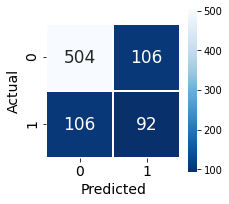

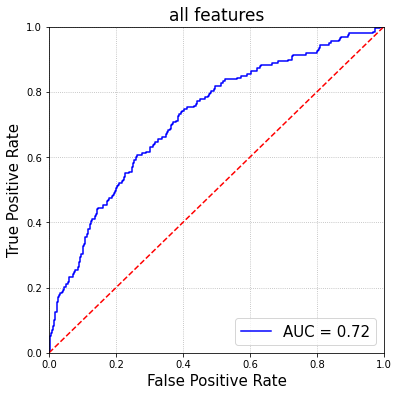

In [ ]:
train_base_models('logistic', 'all')

### Random Forest (Numeric Features Only)

To vary our baseline models, we decided to introduce an ensemble learning method for classification, the Random Forest model. We tried this model with numerical features only and actually got a very interesting result. The accuracy we got was 0.865. This gave us an idea that maybe numerical features were more important than textual features when predicting whether or not someone received a pizza.

--------------------------------------------------------------------------------
numeric features

Accuracy: 0.859

              precision    recall  f1-score   support

       False       0.89      0.93      0.91       610
        True       0.74      0.66      0.70       198

    accuracy                           0.86       808
   macro avg       0.82      0.79      0.81       808
weighted avg       0.86      0.86      0.86       808


Confusion Matrix: 
None


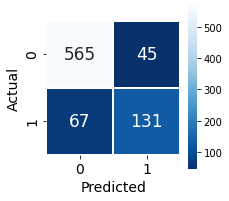

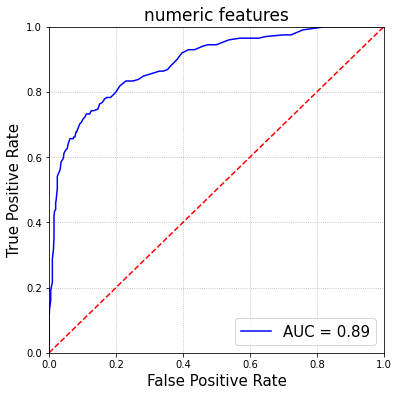

In [ ]:
train_base_models('random_forest', 'numeric')

### Random Forest (All Features)

As a preliminary test to our theory, we incoporated the textual features to the Random Forest model and learned that the accuracy dropped from 0.865 to 0.743. 

We didn't completely rule our textual features moving forward, but this was a mild signal indicating that we might want to focus more on numerical features.

--------------------------------------------------------------------------------
all features

Accuracy: 0.713

              precision    recall  f1-score   support

       False       0.78      0.99      0.87       610
        True       0.79      0.13      0.23       198

    accuracy                           0.78       808
   macro avg       0.78      0.56      0.55       808
weighted avg       0.78      0.78      0.71       808


Confusion Matrix: 
None


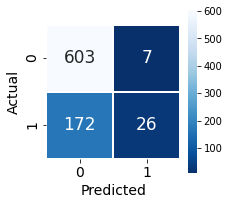

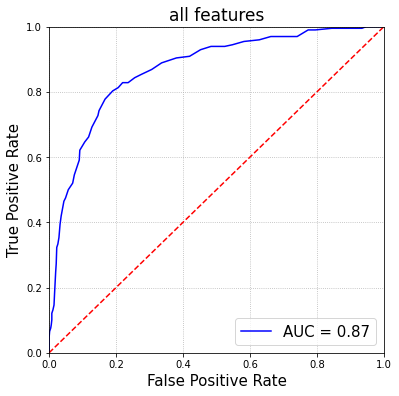

In [ ]:
train_base_models('random_forest', 'all')

### Gaussian Naive Bayes (Numeric Features Only)

Afterwards, we ran a Gaussian Naive Bayes model with numerical features only. The results were not particularly good, with the accuracy at 0.740.

--------------------------------------------------------------------------------
numeric features

Accuracy: 0.740

              precision    recall  f1-score   support

       False       0.81      0.88      0.84       610
        True       0.50      0.36      0.42       198

    accuracy                           0.75       808
   macro avg       0.65      0.62      0.63       808
weighted avg       0.73      0.75      0.74       808


Confusion Matrix: 
None


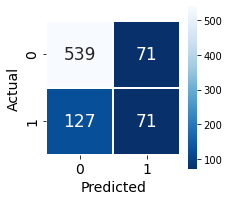

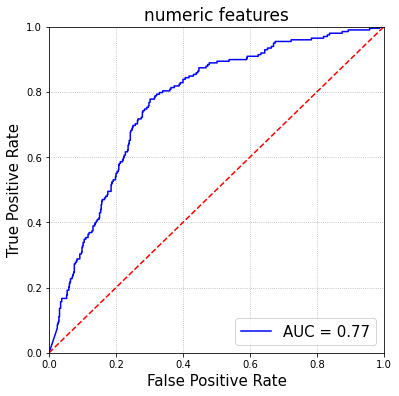

In [ ]:
train_base_models('gaussian_nb', 'numeric')

## Feature Engineering

### Topic Modeling

After data cleansing, we performed LDA-based topic modeling. We got the idea from [research that we found on the Kaggle competition page](https://cs.stanford.edu/~althoff/raop-dataset/altruistic_requests_icwsm.pdf). We read that the writers of the research paper performed topic modeling through non-negative matrix factorization (NMF) of a TF-IDF weighted bag-of-words representation. 

We ran our own LDA model to generate five topics, which resulted a dataframe containing counts for each topic. We added these new features to the train and test datasets.

In [ ]:
# Generate topic features

# generate topic dictionary
topic_dct = topicModeling(train.title_and_text_cleaned)

# add features to train and test 
train = pd.concat([train, genTopics(train.title_and_text_cleaned, topic_dct)], axis=1)
test = pd.concat([test, genTopics(test.title_and_text_cleaned, topic_dct)], axis=1)

### Altruistic Request Features

We decided to incorporate new features based off of the `Altruistic Requests` from the [research paper that we found on the Kaggle competition page](https://cs.stanford.edu/~althoff/raop-dataset/altruistic_requests_icwsm.pdf). The main idea was that genuine pizza requests were actually effective. The notion that people were altruistic and had an unselfish concern for other people would lead them to grant pizza requests depending on the situation. We leveraged this knowledge that was discovered in this paper for our feature engineering below.

#### Narratives Features

We created narratives features. We calculated normalized word frequency of the sentence per narrative (word freq / sentence length). Narrative is a dictionary containing word list per narrative. Returns normalized frequency dictionary.

We followed the list of keywords associated with the following five narratives in the research paper: "Money", "Job", "Student", "Family", and "Craving". We followed the key terms that they identified and created fields based on the existence of these key terms. These narratives are modeled as Binary variables (whether the text contains or does not contain a narrative).

In [ ]:
# Generate narrative feature
train = pd.concat([train, genNarrative(train.title_and_text_cleaned)], axis=1)
test = pd.concat([test, genNarrative(test.title_and_text_cleaned)], axis=1)


To see how each narrative affects the chance of getting pizza, we calculated the success rate comparing if a text / title contains versus do not contain such narrative. 

From the plots, we can see that "Money", "Job", "Student", and "Family" narratives increase the probability of success while "Craving" has negative impact on the success rate.

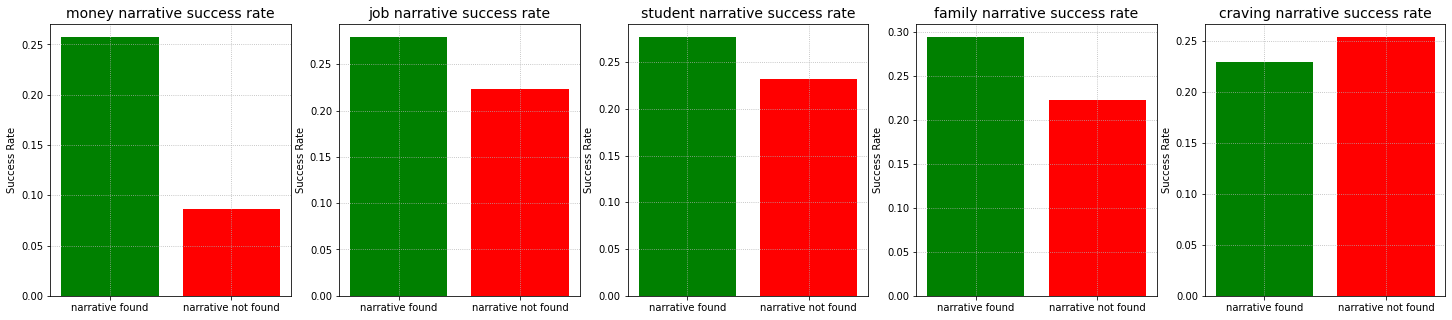

In [ ]:
# Visualize narrative success rate

plt.figure(figsize=(25,5))
col_list = ['money', 'job', 'student', 'family', 'craving']
for i in range(len(col_list)):
    col = col_list[i]
    srate_true = len(train[(train[col] == 1) & (train.requester_received_pizza == True)]) / len(train[train[col] == 1])
    srate_false = len(train[(train[col] == 0) & (train.requester_received_pizza == True)]) / len(train[train[col] == 0])
    plt.subplot(1,len(col_list),i+1)
    plt.bar(['narrative found', 'narrative not found'], [srate_true, srate_false], color=['green','red'])
    plt.title(col+' narrative success rate', fontsize=14)
    plt.ylabel('Success Rate')
    plt.grid(linestyle='dotted')

#### Temporal Features

We created a temporal feature that calculates the time difference between the request timestamp and the date when RAOP community started (December 8, 2010). We scaled the values using decile scale with quantile binings. The result is a scale from 1 - 10.

The idea is that if the "age" of the post is shorter, that's a good indicator that the post would receive pizza. Reddit threads are typically more popular when they first emerge, and gradually lose that popularity over time. The higher popularity helps with upvotes and visiblity, thus contributing to the likelihood of whether or not a post receives pizza. 

In [ ]:
# Generate community age feature
train = pd.concat([train, genCommAge(train.unix_timestamp_of_request_utc)], axis=1)
test = pd.concat([test, genCommAge(test.unix_timestamp_of_request_utc)], axis=1)


As the following plot shows, success rate declines as community age increases.

Text(0.5, 1.0, 'Success rate vs Community Age')

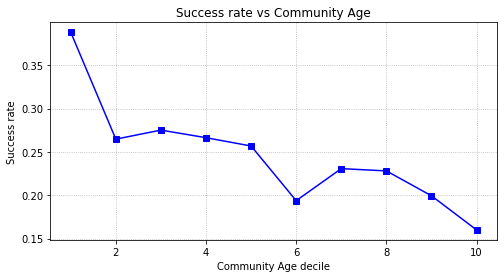

In [ ]:
# Visualization
decile = list(range(1,11))
succrate = [ train[(train.comm_age == d) & (train.requester_received_pizza == True)].size / train[(train.comm_age == d)].size  for d in decile ]
plt.figure(figsize=(8,4))
plt.plot(decile, succrate, marker = 's', color='blue')
plt.grid(linestyle='dotted')
plt.xlabel('Community Age decile')
plt.ylabel('Success rate')
plt.title('Success rate vs Community Age')

#### Gratitude (Politeness) Features

We created a Gratitude (politeness) feature. This indicates whether or not a post was filled with a sense of gratitude via the existence of any of the following words: "thank", "appreciate", or "advance". This is a binary variable (contains or does not contain gratitude words).

If a post was signaling some sign of thanks or gratitude, it was a good signal of whether it would received pizza. People were more likely to behave altruistically towards these people who indicated that they were grateful and thankful.

In [ ]:
# Generate gratitude feature
train = pd.concat([train, genGrat(train.title_and_text_cleaned)], axis=1)
test = pd.concat([test, genGrat(test.title_and_text_cleaned)], axis=1)


Below plot shows higher success rate for text with gratitude compared to the ones without.

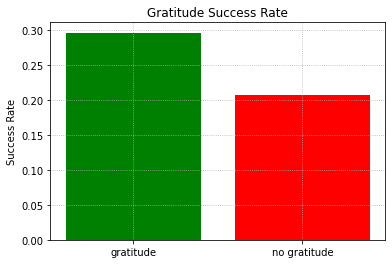

In [ ]:
# Visualize gratitude success rate
srate_grat = len(train[(train.gratitude == 1) & (train.requester_received_pizza == True)]) / len(train[train.gratitude == 1])
srate_nograt = len(train[(train.gratitude == 0) & (train.requester_received_pizza == True)]) / len(train[train.gratitude == 0])

plt.figure()
plt.bar(['gratitude', 'no gratitude'], [srate_grat, srate_nograt], color=['green','red'])
plt.title('Gratitude Success Rate')
plt.ylabel('Success Rate')
plt.grid(linestyle='dotted')

#### Including Image or Links (Evidentiality) Features

We created a evidentialiity feature. This indicates whether or not a post included extra links or supplemental information to support their request. This was indicated by the existence of either "http" or "www". This is a binary variable.

At times, the request text may not be enough. Some of the requests can be hard to believe, and having evidence or proof of some aspect of a request is helpful in indicating whether or not people will be willing to grant pizza. People want to know that their altruistic act of granting pizza is not just in vain and that the post isn't made up in order to get free pizza.

In [ ]:
# Generate link feature
train = pd.concat([train, genLink(train.title_and_text_cleaned)], axis=1)
test = pd.concat([test, genLink(test.title_and_text_cleaned)], axis=1)


The success rate plot shows that having link in the text increases the chance of getting pizza.

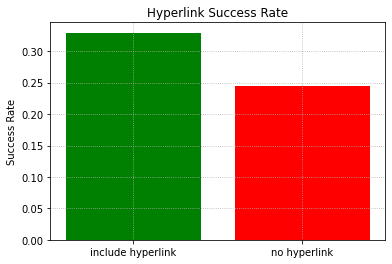

In [ ]:
# Visualize gratitude success rate
srate_link = len(train[(train.links == 1) & (train.requester_received_pizza == True)]) / len(train[train.links == 1])
srate_nolink = len(train[(train.links == 0) & (train.requester_received_pizza == True)]) / len(train[train.links == 0])

plt.figure()
plt.bar(['include hyperlink', 'no hyperlink'], [srate_link, srate_nolink], color=['green','red'])
plt.title('Hyperlink Success Rate')
plt.ylabel('Success Rate')
plt.grid(linestyle='dotted')

#### Reciprocity Feature

We created a reciprocity feature (binary type). This indicates whether or not a post intended to reciprocate to the altrusitic act in some way. This was indicated by the existence of the terms "pay ... forward" , "pay ... back", "return ... favor", or "repay".

Posts were more likely to get pizza if there was some sort of indication that the altuistic act would be paid forward. If someone were to give pizza, they would want to know that the person they are giving pizza to will also try to return the favor in some way.

In [ ]:
# Generate reciprocity feature
train = pd.concat([train, genRecip(train.title_and_text_cleaned)], axis=1)
test = pd.concat([test, genRecip(test.title_and_text_cleaned)], axis=1)


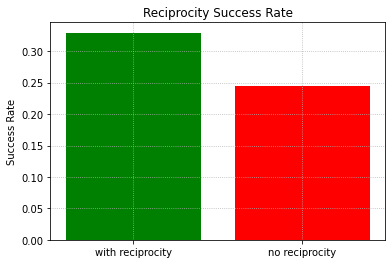

In [ ]:
# Visualize reciprocity success rate
srate_recip = len(train[(train.reciprocity == 1) & (train.requester_received_pizza == True)]) / len(train[train.reciprocity == 1])
srate_norecip = len(train[(train.reciprocity == 0) & (train.requester_received_pizza == True)]) / len(train[train.reciprocity == 0])

plt.figure()
plt.bar(['with reciprocity', 'no reciprocity'], [srate_link, srate_nolink], color=['green','red'])
plt.title('Reciprocity Success Rate')
plt.ylabel('Success Rate')
plt.grid(linestyle='dotted')

#### Request Length Feature

We created a request length feature. This will return a decile length of the post.

Explaining more about the context of the request (and thus increasing the text length), is a good signal of whether or not a pizza will be received. People want to know their pizza is going towards a detailed, believable cause.

In [ ]:
# Generate Request Length feature 
train = pd.concat([train, genReqLen(train.title_and_text_cleaned)], axis=1)
test = pd.concat([test, genReqLen(test.title_and_text_cleaned)], axis=1)


The following plot shows that longer text has higher success rate.

Text(0.5, 1.0, 'Success rate vs Request Length')

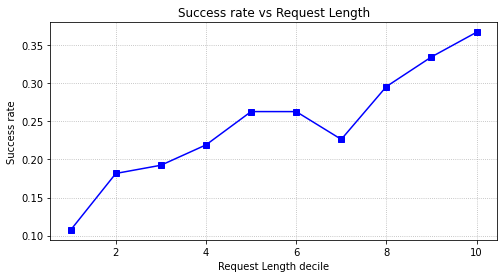

In [ ]:
# Visualization
decile = list(range(1,11))
succrate = [ train[(train.request_length == d) & (train.requester_received_pizza == True)].size / train[(train.request_length == d)].size  for d in decile ]
plt.figure(figsize=(8,4))
plt.plot(decile, succrate, marker = 's', color='blue')
plt.grid(linestyle='dotted')
plt.xlabel('Request Length decile')
plt.ylabel('Success rate')
plt.title('Success rate vs Request Length')

#### Karma Feature (uses `requester_upvotes_minus_downvotes_at_request`)

We created a Karma feature. This is using the Requester Upvotes Minus Downvotes At Request field, scaled to decile (1-10).

This is a good indicator for visibility. In Reddit, higher Karma counts float to the top. These posts will get more views and more opportunities to receive pizza from these additional viewers.

In [ ]:
# Generate Karma feature
train = pd.concat([train, genKarma(train.requester_upvotes_minus_downvotes_at_request)], axis=1)
test = pd.concat([test, genKarma(test.requester_upvotes_minus_downvotes_at_request)], axis=1)


As the plot shows, higher reddit status (indicated by more upvotes) increases the success rate.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in long_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


Text(0.5, 1.0, 'Success rate vs Karma')

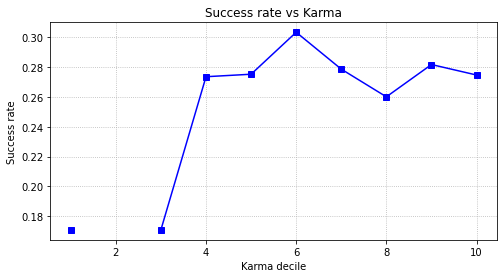

In [ ]:
# Visualization
decile = list(range(1,11))
succrate = [ train[(train.karma == d) & (train.requester_received_pizza == True)].size / train[(train.karma == d)].size  for d in decile ]
plt.figure(figsize=(8,4))
plt.plot(decile, succrate, marker = 's', color='blue')
plt.grid(linestyle='dotted')
plt.xlabel('Karma decile')
plt.ylabel('Success rate')
plt.title('Success rate vs Karma')

#### Post history feature (uses `requester_number_of_posts_on_raop_at_request`)

We created a Post-History feature (binary type). This is using the Requester Number of Posts on RAOP at Request.

If a requester in more involved in the RAOP community, meaning they have posted in the past, that could help signal a successful pizza request. If an individual is very new to the community, it could be hard to garner interest from others.

In [ ]:
# Generate "posted before" feature
train = pd.concat([train, genPostedbefore(train.requester_number_of_posts_on_raop_at_request)], axis=1)
test = pd.concat([test, genPostedbefore(test.requester_number_of_posts_on_raop_at_request)], axis=1)


As the plot shows, those who posted at RAOP before has higher success rate than those who never posted before.

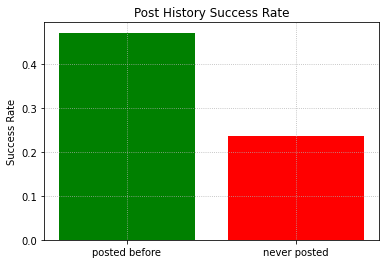

In [ ]:
# Visualize success rate
postbefore_true = train[(train.posted_before == 1) & (train.requester_received_pizza == True)].size / train[train.posted_before == 1].size
postbefore_false = train[(train.posted_before == 0) & (train.requester_received_pizza == True)].size / train[train.posted_before == 0].size

plt.figure()
plt.bar(['posted before', 'never posted'], [postbefore_true, postbefore_false], color=['green','red'])
plt.title('Post History Success Rate')
plt.ylabel('Success Rate')
plt.grid(linestyle='dotted')

##Selection of Features (using PCA and Correlation matrix)

After engineering our new features, we evaluated the contribution of all numerical features using PCA. The goal was to identify the most influential features. 

From the Scree plot, we can see that PCA1 represents the majority of the explained variance. We therefore only look at PCA1 to see the loading scores of the features.

We identified a list of 20 most influential features. We will use the top four features for our final models: 

1. requester_upvotes_plus_downvotes_at_retrieval
2. requester_upvotes_plus_downvotes_at_request
3. requester_upvotes_minus_downvotes_at_retrieval
4. requester_upvotes_minus_downvotes_at_request

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


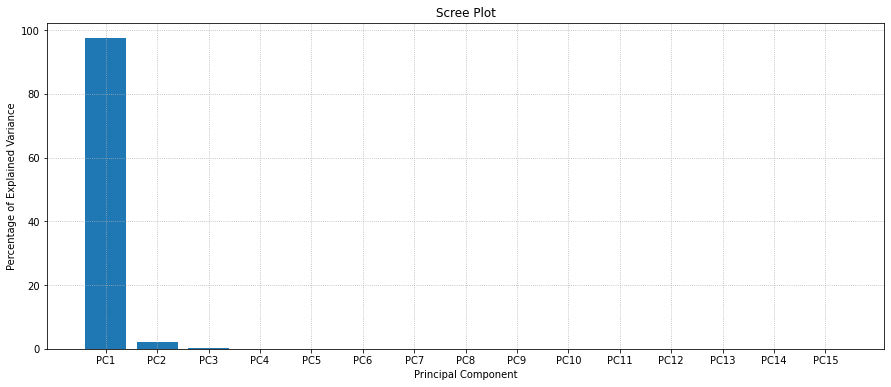

In [ ]:
# Create copy of numerical dataframe and drop unnecessary columns 
train_numerical_pca = train.select_dtypes('number')
train_numerical_pca.drop(columns=['post_was_edited','unix_timestamp_of_request','unix_timestamp_of_request_utc'], inplace=True)

# Create PCA
pca = PCA(n_components=15)
pca_data = pca.fit_transform(train_numerical_pca) 

# Scree plot
per_var = np.round(pca.explained_variance_ratio_* 100, decimals=1)
labels = ['PC' + str(x) for x in range(1, len(per_var)+1)]

plt.figure(figsize=(15,6))
plt.bar(x=range(1,len(per_var)+1), height=per_var, tick_label=labels)
plt.ylabel('Percentage of Explained Variance')
plt.xlabel('Principal Component')
plt.title('Scree Plot')
plt.grid(linestyle='dotted')

In [ ]:
# Find the top features within PCA1
loading_scores = pd.Series(pca.components_[0], index=train_numerical_pca.columns)
sorted_loading_scores = loading_scores.abs().sort_values(ascending=False)
# Print top 20 features
top_index = sorted_loading_scores[0:20].index.values
print(loading_scores[top_index])

requester_upvotes_plus_downvotes_at_retrieval           0.835232
requester_upvotes_plus_downvotes_at_request             0.534644
requester_upvotes_minus_downvotes_at_retrieval          0.109144
requester_upvotes_minus_downvotes_at_request            0.068034
requester_number_of_comments_at_retrieval               0.001306
requester_number_of_posts_at_retrieval                  0.000519
requester_account_age_in_days_at_request                0.000514
requester_number_of_comments_at_request                 0.000435
requester_number_of_posts_at_request                    0.000323
requester_account_age_in_days_at_retrieval              0.000265
requester_days_since_first_post_on_raop_at_retrieval   -0.000139
requester_days_since_first_post_on_raop_at_request      0.000112
requester_number_of_subreddits_at_request               0.000066
len_request_text_edit_aware                            -0.000024
len_request_text                                       -0.000020
karma                    


Next, we ran a correlation matrix to get the high-correlation features with the `requester_received_pizza` variable. We will use the highest ones in our final model.

In [ ]:
corrmatrix = train.corr(method='pearson')
corrmatrix['requester_received_pizza'].sort_values(ascending=False)

requester_received_pizza                                1.000000
requester_number_of_posts_on_raop_at_retrieval          0.450079
request_number_of_comments_at_retrieval                 0.292555
requester_number_of_comments_in_raop_at_retrieval       0.273619
request_length                                          0.155219
num_punct_request_text                                  0.147519
topic1                                                  0.147310
requester_number_of_posts_on_raop_at_request            0.138930
requester_days_since_first_post_on_raop_at_retrieval    0.138613
num_punct_request_text_edit_aware                       0.132165
topic4                                                  0.131875
requester_number_of_comments_in_raop_at_request         0.128281
requester_account_age_in_days_at_retrieval              0.125925
len_request_text                                        0.125303
posted_before                                           0.117043
len_request_text_edit_awa

Based on PCA and Correlation analysis, we selected the features that had the most meaningful impact. With further iterations, our features that give the best performance are as listed below. We ended up not using the topics (which were automatedly created using LDA) since not using them give better perfomance.

In [ ]:
# Selected columns from correlaton, pca, topic modeling, and altruistic

corr_cols = ['requester_number_of_posts_on_raop_at_retrieval',
       'request_number_of_comments_at_retrieval',
       'requester_number_of_comments_in_raop_at_retrieval',
       'num_punct_request_text',
       'requester_number_of_posts_on_raop_at_request',
       'requester_days_since_first_post_on_raop_at_retrieval',
       'requester_number_of_comments_in_raop_at_request',
       'requester_account_age_in_days_at_retrieval', 'len_request_text',
       'requester_number_of_comments_at_retrieval']

pca_cols = ['requester_upvotes_plus_downvotes_at_retrieval',
       'requester_upvotes_plus_downvotes_at_request',
       'requester_upvotes_minus_downvotes_at_retrieval',
       'requester_upvotes_minus_downvotes_at_request']

topic_cols = ['topic0', 'topic1', 'topic2', 'topic3', 'topic4']

#altr_cols = ['money', 'job', 'student', 'family', 'craving', 'comm_age',
#       'gratitude', 'links', 'reciprocity', 'request_length', 'karma', 'posted_before']

altr_cols = ['money', 'job', 'family', 'comm_age', 'gratitude', 'links']

#select_cols = corr_cols + pca_cols + topic_cols + altr_cols
select_cols = corr_cols + pca_cols + altr_cols # this contains all of our final features

train_s = train[select_cols]
test_s = test[select_cols]


## Final Models

For our final models, we decided to re-run a few of the models we used in our baseline and add two more. Because we saw that the Random Forest model performed the best, we decided to add two other ensemble method models: Gradient Boosting and ADA Boosting. For all models, we used only the features we selected based on the results of the PCA and Correlation matrix.

### Logistic Regression

When we ran our baseline logistic regression model, our accuracy was at 0.738, AUC was 0.72, and the F1-Score for True was 0.46. 

We saw an improvement to an accuracy of 0.761, AUC was 0.80, and the F1-Score for True was 0.58.

We were a bit surprised that this didn't perform better. Since our outcome variable was binary, we originally thought this model would perform the best, but that was not the case.

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


--------------------------------------------------------------------------------
Logistic Regression

Accuracy: 0.761

              precision    recall  f1-score   support

       False       0.89      0.77      0.82       610
        True       0.49      0.70      0.58       198

    accuracy                           0.75       808
   macro avg       0.69      0.73      0.70       808
weighted avg       0.79      0.75      0.76       808


Confusion Matrix: 


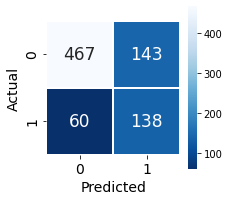

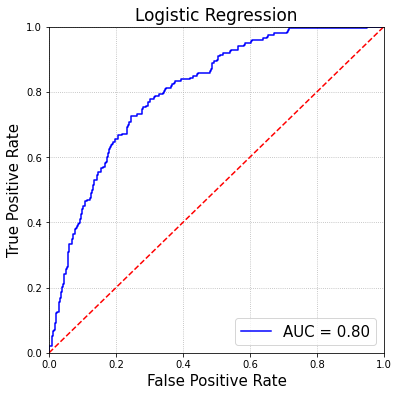

In [ ]:
log_s = LogisticRegression(class_weight = 'balanced', max_iter=500)
log_s.fit(train_s, train_labels)
pred_log = log_s.predict(test_s)
eval_perf('Logistic Regression', test_labels, pred_log, log_s.predict_proba(test_s))

### Random Forests

When we ran our baseline random forest model with numeric features only, our accuracy was at 0.859, AUC was 0.89, and the F1-Score for True was 0.70. 

For our baseline random forest model with both textual and numerical features, our accuracy was at 0.750, AUC was 0.87, and the F1-Score for True was 0.35. 

We saw an improvement to an accuracy of 0.863, AUC was 0.89, and the F1-Score for True was 0.71.

Our baseline model with just numeric features performed very well. Even after engineering several features for our final set of models, this final model only performed marginally better than the baseline one. However, this one is much more justifiable in terms of the motivation behind the features used. We cannot go with our original baseline model because we just ran it with all the features without much thought. We did not think this was appropriate and therefore were pleased with the results after all of our iterating.

--------------------------------------------------------------------------------
Random Forest

Accuracy: 0.862

              precision    recall  f1-score   support

       False       0.89      0.94      0.91       610
        True       0.77      0.65      0.70       198

    accuracy                           0.87       808
   macro avg       0.83      0.79      0.81       808
weighted avg       0.86      0.87      0.86       808


Confusion Matrix: 


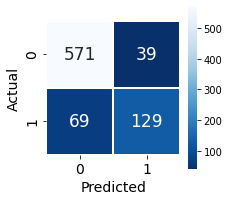

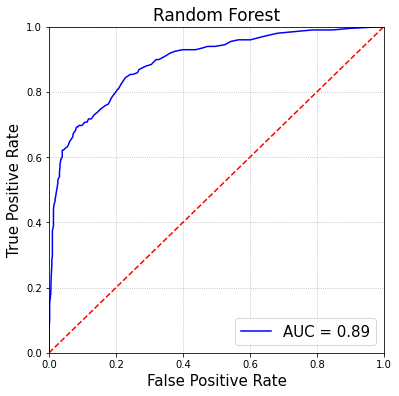

In [ ]:
rf_s = RandomForestClassifier()
rf_s.fit(train_s, train_labels)
pred_rf = rf_s.predict(test_s)
eval_perf('Random Forest', test_labels, pred_rf, rf_s.predict_proba(test_s))

### Gaussian Naive Bayes

When we ran our baseline gaussian naive bayes model with numeric features only, our accuracy was at 0.749, AUC was 0.77, and the F1-Score for True was 0.42. 

We saw performance degradation with accuracy of 0.712, AUC of 0.72, and the F1-Score for True of 0.29

The Gaussian Naive Bayes model performed worse with our final features.

--------------------------------------------------------------------------------
Gaussian Naive Bayes

Accuracy: 0.712

              precision    recall  f1-score   support

       False       0.78      0.93      0.85       610
        True       0.49      0.20      0.29       198

    accuracy                           0.75       808
   macro avg       0.64      0.57      0.57       808
weighted avg       0.71      0.75      0.71       808


Confusion Matrix: 


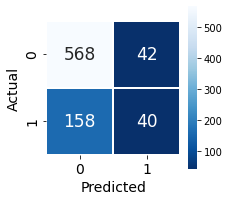

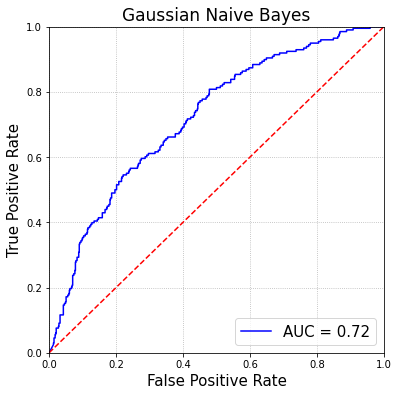

In [ ]:
gnb_s = GaussianNB()
gnb_s.fit(train_s, train_labels)
pred_gnb = gnb_s.predict(test_s)
eval_perf('Gaussian Naive Bayes', test_labels, pred_gnb, gnb_s.predict_proba(test_s))

### Gradient Boosting

For our gradient boosting model, our accuracy of 0.862, AUC was 0.90, and the F1-Score for True was 0.71.

The Gradient Boosting final model performed the best out of all our models with the final selection of features. When we ran our Random Forest baseline model, it was a signal that ensemble method models may perform better. This was the case indeed, since both the Gradient Boosting model and ADA Bossting model (below) performed quite well.

Due to the higher F1-score for True labels and AUC, this Gradient Boosting Model will become our **final** model.

--------------------------------------------------------------------------------
Gradient Boosting

Accuracy: 0.862

              precision    recall  f1-score   support

       False       0.90      0.92      0.91       610
        True       0.74      0.68      0.71       198

    accuracy                           0.86       808
   macro avg       0.82      0.80      0.81       808
weighted avg       0.86      0.86      0.86       808


Confusion Matrix: 


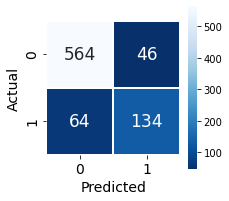

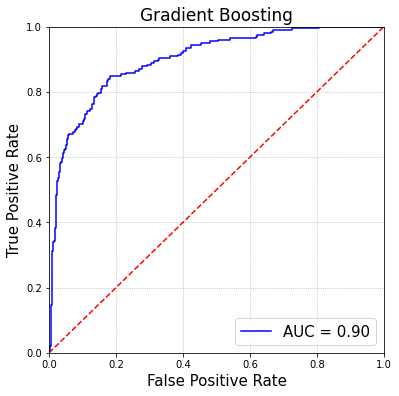

In [ ]:
gb_s = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)
gb_s.fit(train_s, train_labels)
pred_gb = gb_s.predict(test_s)
eval_perf('Gradient Boosting', test_labels, pred_gb, gb_s.predict_proba(test_s))

### ADA Boosting

For our gradient boosting model, our accuracy of 0.858, AUC was 0.90, and the F1-Score for True was 0.69.

The ADA Boosting model performed similarly to our other final models. It is a ensemble method model so we expected to perform this well with our particular dataset.

--------------------------------------------------------------------------------
AdaBoost

Accuracy: 0.858

              precision    recall  f1-score   support

       False       0.89      0.94      0.91       610
        True       0.77      0.63      0.69       198

    accuracy                           0.86       808
   macro avg       0.83      0.78      0.80       808
weighted avg       0.86      0.86      0.86       808


Confusion Matrix: 


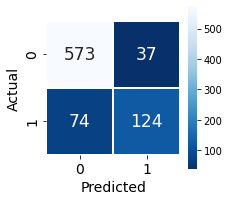

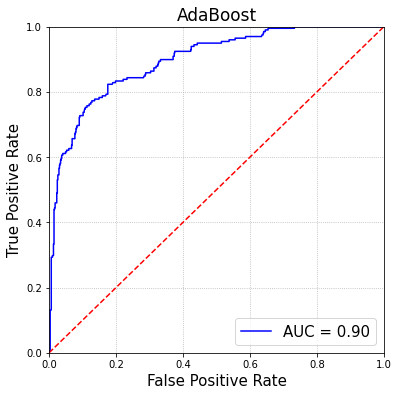

In [ ]:
ada_clf = AdaBoostClassifier(
DecisionTreeClassifier(max_depth=1), n_estimators=500,
algorithm="SAMME.R", learning_rate=0.05
)
ada_clf.fit(train_s, train_labels)
pred_ada = ada_clf.predict(test_s)
eval_perf('AdaBoost', test_labels, pred_ada, ada_clf.predict_proba(test_s))

# END OF NOTEBOOK

# Appendix
This section documents some of our previous experiments that are not used in our main work.

## NLP Experiments (Not Used in our model)
Our initial focus is on processing text using NLP techniques to make predictions. The following sections contain those efforts.

### Sentiment Score

We experimented with Vader Sentiment score to see if sentiment can give us output prediction. The sentiment scores become the inputs to the Logistic Regression mode. However the model is unable to predict the True outcome properly.

--------------------------------------------------------------------------------
Vader Sentiment

Accuracy: 0.482

              precision    recall  f1-score   support

       False       0.76      0.40      0.52       610
        True       0.25      0.61      0.35       198

    accuracy                           0.45       808
   macro avg       0.50      0.51      0.44       808
weighted avg       0.63      0.45      0.48       808


Confusion Matrix: 


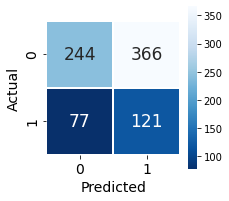

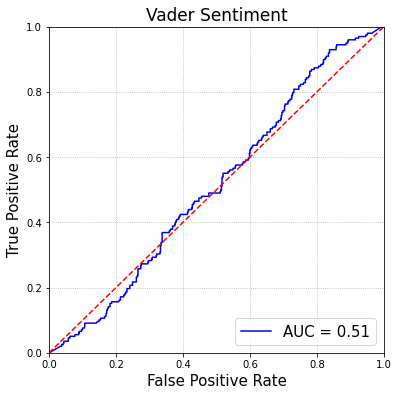

In [ ]:
# Vader Sentiment
feats = ['request_text_vader_neg','request_text_vader_pos','request_text_vader_neu']
xtrain = train[feats]
xtest = test[feats]

# Logistic Regression Model
lr = LogisticRegression(class_weight='balanced')
lr.fit(xtrain, train_labels)
pred = lr.predict(xtest)
proba = lr.predict_proba(xtest)
eval_perf('Vader Sentiment', test_labels, pred, proba)


### Document Term Matrix (Count Vectorizer)

In this experiment, we are attempting to vectorize the text using word frequency count and feed the vector to Logistic Regression model. We are also trying to visualize the vectorized features to see if we can see clusters separating the two prediction outcome. From the scatter plot, we are unable to see any clear separation. 

--------------------------------------------------------------------------------
Count Vectorizer

Accuracy: 0.662

              precision    recall  f1-score   support

       False       0.78      0.78      0.78       610
        True       0.31      0.31      0.31       198

    accuracy                           0.66       808
   macro avg       0.54      0.54      0.54       808
weighted avg       0.66      0.66      0.66       808


Confusion Matrix: 


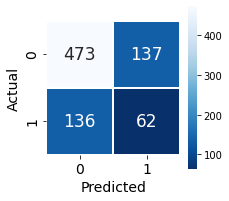

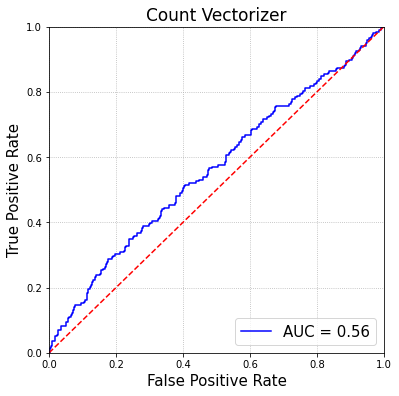

In [ ]:
# Count Vectorizer
cv = CountVectorizer()
xtrain = cv.fit_transform(train.title_and_text_cleaned)
xtest = cv.transform(test.title_and_text_cleaned)

# Logistic Regression Model
lr = LogisticRegression(class_weight='balanced', max_iter=500)
lr.fit(xtrain, train_labels)
pred = lr.predict(xtest)
proba = lr.predict_proba(xtest)
eval_perf('Count Vectorizer', test_labels, pred, proba)

Text(0, 0.5, 'PCA 2')

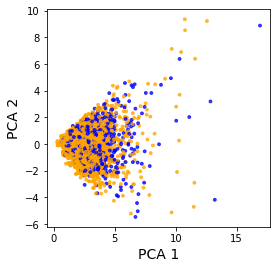

In [ ]:
# Create PCA
pca = TruncatedSVD(n_components=2)
pca_train = pca.fit_transform(xtrain) 
pca_test = pca.transform(xtest)
colors = ['orange','blue']
plt.figure(figsize=(4,4))
plt.scatter(pca_train[:,0], pca_train[:,1], s=8, alpha=0.75, c=train_labels, cmap=matplotlib.colors.ListedColormap(colors))
plt.xlabel('PCA 1', fontsize=14)
plt.ylabel('PCA 2', fontsize=14)

### TF IDF Vectorizer  
By using TF-IDF vectorizer, we were hoping to get a better data separation between the two output prediction class. However we did not see noticable improvement compared to Count Vectorizer.

--------------------------------------------------------------------------------
TF IDF

Accuracy: 0.666

              precision    recall  f1-score   support

       False       0.80      0.72      0.76       610
        True       0.34      0.45      0.39       198

    accuracy                           0.65       808
   macro avg       0.57      0.58      0.57       808
weighted avg       0.69      0.65      0.67       808


Confusion Matrix: 


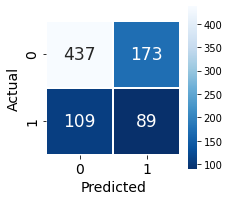

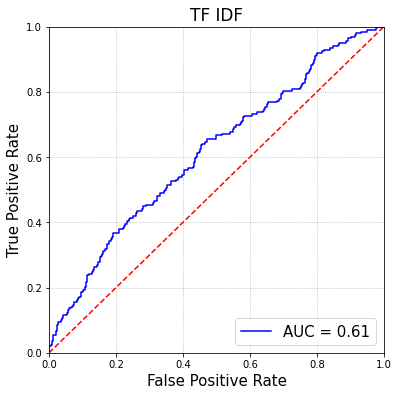

In [ ]:
# TF IDF Vectorizer
tf = TfidfVectorizer()
xtrain = tf.fit_transform(train.title_and_text_cleaned)
xtest = tf.transform(test.title_and_text_cleaned)

# Logistic Regression Model
lr = LogisticRegression(class_weight='balanced', max_iter=500)
lr.fit(xtrain, train_labels)
pred = lr.predict(xtest)
proba = lr.predict_proba(xtest)
eval_perf('TF IDF', test_labels, pred, proba)

Text(0, 0.5, 'PCA 2')

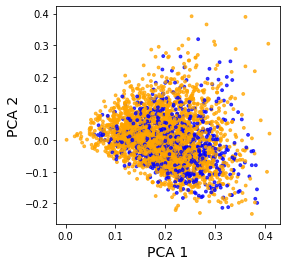

In [ ]:
# Create PCA
pca = TruncatedSVD(n_components=2)
pca_train = pca.fit_transform(xtrain) 
pca_test = pca.transform(xtest)
colors = ['orange','blue']
plt.figure(figsize=(4,4))
plt.scatter(pca_train[:,0], pca_train[:,1], s=8, alpha=0.75, c=train_labels, cmap=matplotlib.colors.ListedColormap(colors))
plt.xlabel('PCA 1', fontsize=14)
plt.ylabel('PCA 2', fontsize=14)

### Doc2Vec Vectorizer
Our motivation to use Doc2Vec is to get a better vector representation of the text since it preserves the symantic of the document. However, this too failed to separate the data properly and we are unable to get improvement on model performance.

In [ ]:
# Doc2Vec

def tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sent):
            if len(word) < 2:
                continue
            tokens.append(word.lower())
    return tokens

# create tagged document
train_tagged = train.apply(lambda r: TaggedDocument(words=tokenize_text(r['title_and_text_cleaned']), tags=[r.requester_received_pizza]), axis=1)
test_tagged = test.apply(lambda r: TaggedDocument(words=tokenize_text(r['title_and_text_cleaned']), tags=[r.requester_received_pizza]), axis=1)

# Create model and build vocab
model_dbow = Doc2Vec(dm=0, vector_size=100, negative=5, hs=0, min_count=2, sample = 0)
model_dbow.build_vocab([x for x in tqdm(train_tagged.values)])

100%|██████████| 3232/3232 [00:00<00:00, 650666.72it/s]


In [ ]:
%%time
for epoch in range(30):
    model_dbow.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha

100%|██████████| 3232/3232 [00:00<00:00, 1832633.57it/s]


CPU times: user 12.2 s, sys: 1.11 s, total: 13.3 s
Wall time: 9.11 s


--------------------------------------------------------------------------------
Doc2Vec

Accuracy: 0.534

              precision    recall  f1-score   support

       False       0.80      0.46      0.58       610
        True       0.28      0.64      0.39       198

    accuracy                           0.50       808
   macro avg       0.54      0.55      0.48       808
weighted avg       0.67      0.50      0.53       808


Confusion Matrix: 


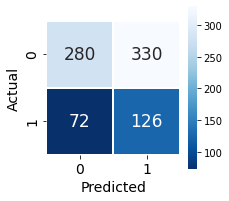

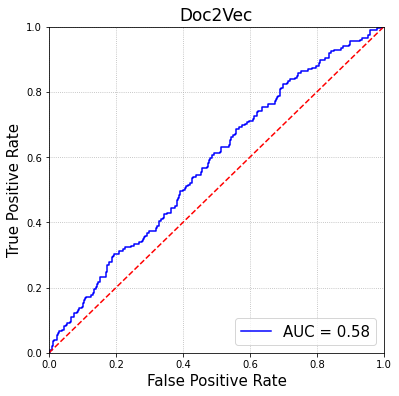

In [ ]:
def vec_for_learning(model, tagged_docs):
    sents = tagged_docs.values
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=20)) for doc in sents])
    return targets, regressors

y_train, xtrain = vec_for_learning(model_dbow, train_tagged)
y_test, xtest = vec_for_learning(model_dbow, test_tagged)

# Logistic Regression Model
lr = LogisticRegression(class_weight='balanced', max_iter=500)
lr.fit(xtrain, train_labels)
pred = lr.predict(xtest)
proba = lr.predict_proba(xtest)
eval_perf('Doc2Vec', test_labels, pred, proba)

Text(0, 0.5, 'PCA 2')

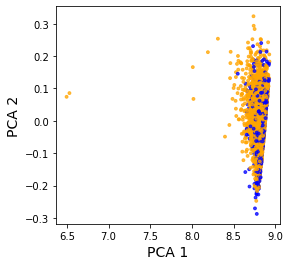

In [ ]:
# Create PCA
pca = TruncatedSVD(n_components=2)
pca_train = pca.fit_transform(xtrain) 
pca_test = pca.transform(xtest)
colors = ['orange','blue']
plt.figure(figsize=(4,4))
plt.scatter(pca_train[:,0], pca_train[:,1], s=8, alpha=0.75, c=train_labels, cmap=matplotlib.colors.ListedColormap(colors))
plt.xlabel('PCA 1', fontsize=14)
plt.ylabel('PCA 2', fontsize=14)